In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#library for Anomaly Detection
from sklearn.neighbors import LocalOutlierFactor

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading data from cpu_utilization csv file, making date as index

cpu_df = pd.read_csv('ec2_cpu_utilization_24ae8d.csv', parse_dates = ['timestamp'], index_col = ['timestamp'])
cpu_df['value'] = cpu_df['value'].astype(float)
cpu_df.index = pd.to_datetime(cpu_df.index)
cpu_df.head(10)


,value
timestamp,
2014-02-14 14:30:00,0.132
2014-02-14 14:35:00,0.134
2014-02-14 14:40:00,0.134
2014-02-14 14:45:00,0.134
2014-02-14 14:50:00,0.134
2014-02-14 14:55:00,0.134
2014-02-14 15:00:00,0.134
2014-02-14 15:05:00,0.134
2014-02-14 15:10:00,0.066


Text(0.5, 1.0, 'AWS Cloudwatch CPU Utilization')

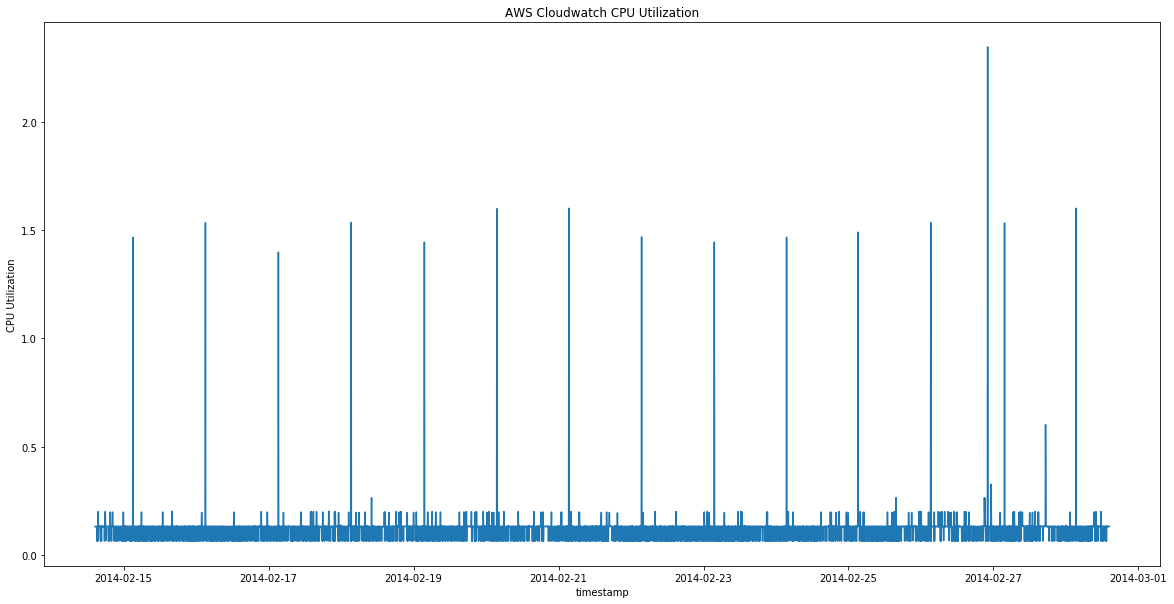

In [3]:
#plotting graph to visualize the data
plt.figure(figsize=(20,10))
plt.xlabel('timestamp')
plt.ylabel('CPU Utilization')
plt.plot(cpu_df.index, cpu_df.value)
plt.title('AWS Cloudwatch CPU Utilization')

In [4]:
#function for Identifying outliers
def detect_outlier(data_1):
    outliers_dates=[]
    outliers=[]
    threshold=3
    
    mean_1 = np.mean(data_1.value)
    std_1 =np.std(data_1.value)
    
    for x, y in zip(data_1.index, data_1.value):
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers_dates.append(x)
            outliers.append(y)
            
    return outliers_dates, outliers

Text(0.5, 1.0, 'Skyline Anomaly Detection on \nAWS Cloudwatch CPU Utilization')

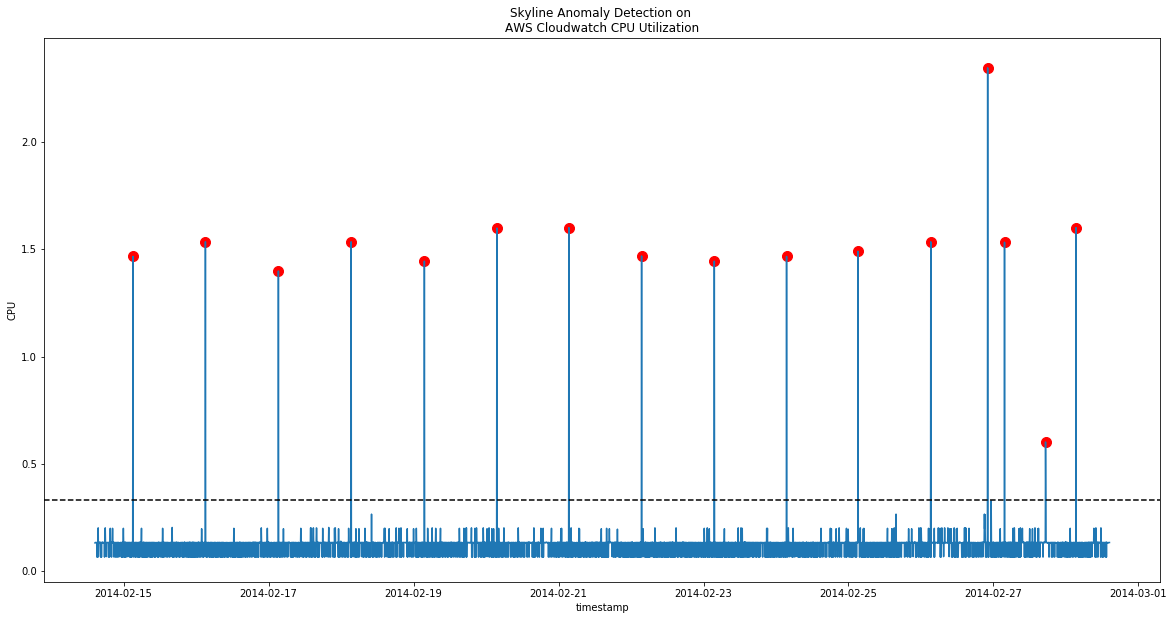

In [5]:
'''
Skyline Anomaly Detection
'''
#Identifying outliers in the dataframe
out_lier_date , out_lier = detect_outlier(cpu_df)

min_outlier = min(out_lier)
sorted_value = sorted(cpu_df.value)

#getting predecessor of minimum outlier value
p=0
for v in sorted_value:
    if v==min_outlier:
        break
    else:
        p=v   

#plotting graph
plt.figure(figsize=(20,10))
plt.xlabel('timestamp')
plt.ylabel('CPU')
#plotting values
plt.plot(cpu_df.index, cpu_df.value)
#plotting outliers
plt.scatter(out_lier_date, out_lier, c='red', s=100)
plt.axhline(p, color='black', linestyle='--')
plt.title('Skyline Anomaly Detection on \nAWS Cloudwatch CPU Utilization')

In [6]:
'''
Local-Outlier Factor
'''
#reading Network Bytes In data from csv file, making date as index

net_df = pd.read_csv('ec2_network_in_5abac7.csv', parse_dates = ['timestamp'], index_col = ['timestamp'])
net_df['value'] = net_df['value'].astype(float)
net_df.index = pd.to_datetime(net_df.index)

net_df = net_df[(net_df.T != 0).any()]
display(net_df.head(10))



,value
timestamp,
2014-03-01 17:36:00,42.0
2014-03-01 17:41:00,94.8
2014-03-01 17:46:00,42.0
2014-03-01 17:51:00,68.4
2014-03-01 17:56:00,68.4
2014-03-01 18:01:00,86.4
2014-03-01 18:06:00,68.4
2014-03-01 18:11:00,42.0
2014-03-01 18:16:00,112.8


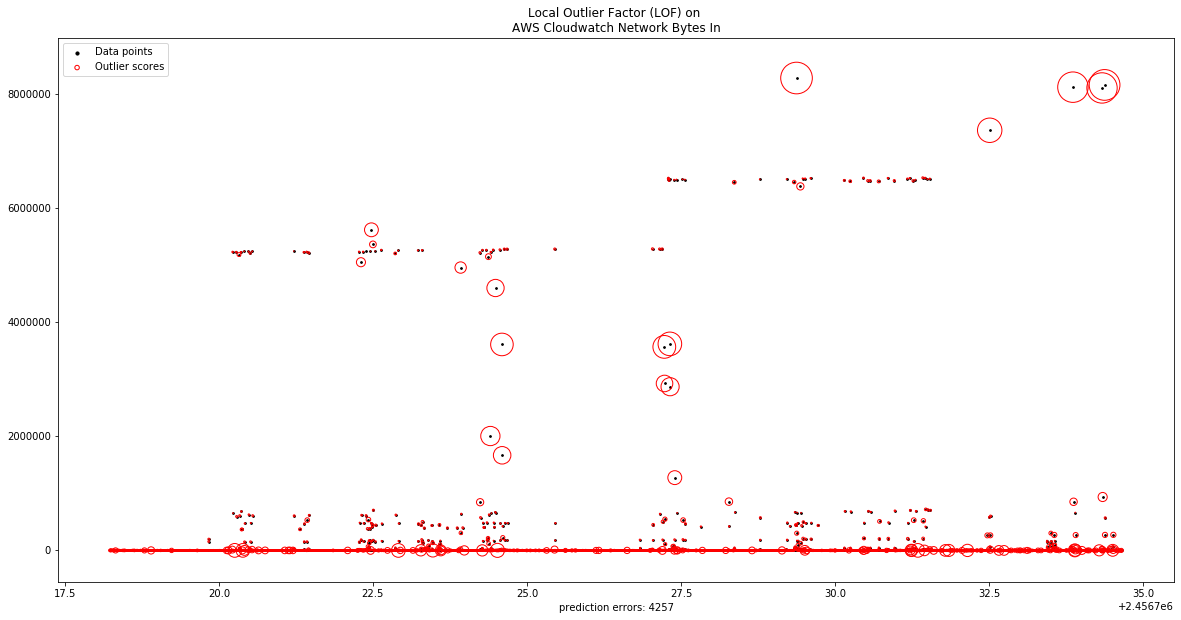

In [7]:

X = np.c_[net_df.index.to_julian_date(), net_df.value]

n_outliers = len(net_df.value)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)

n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.figure(figsize=(20,10))
plt.title("Local Outlier Factor (LOF) on \nAWS Cloudwatch Network Bytes In")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [8]:
'''
IsolationForest
'''
#reading Disk Read Bytes data from csv file, making date as index

disk_df = pd.read_csv('ec2_disk_write_bytes_c0d644.csv', parse_dates = ['timestamp'], index_col = ['timestamp'])
disk_df['value'] = disk_df['value'].astype(float)
disk_df.index = pd.to_datetime(disk_df.index)

disk_df = disk_df[(disk_df.T != 0).any()]
display(disk_df.head(10))


,value
timestamp,
2014-04-02 15:00:00,19949200.0
2014-04-02 15:05:00,48951300.0
2014-04-02 15:10:00,431199000.0
2014-04-02 15:15:00,36434700.0
2014-04-02 15:20:00,1558940.0
2014-04-02 17:05:00,34572700.0
2014-04-02 17:10:00,323807000.0
2014-04-02 17:15:00,143349000.0
2014-04-02 17:20:00,35015100.0


Text(0.5, 1.0, 'Isolation Forest on\nAWS Cloudwatch Disk Read Bytes')

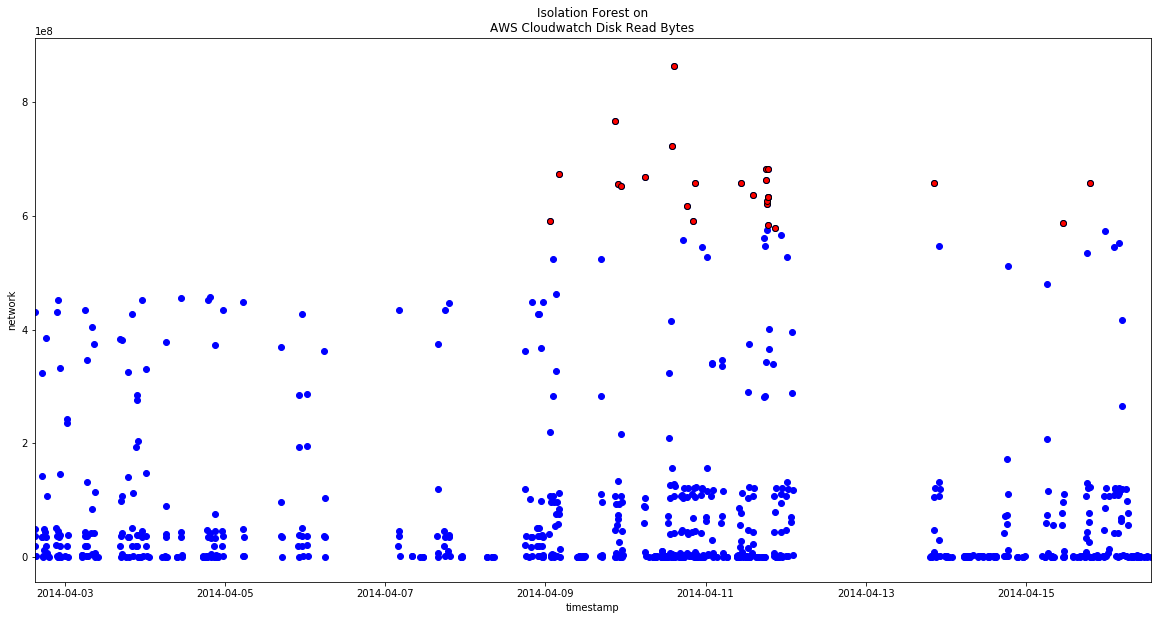

In [9]:
#Identifying outliers in the dataframe
out_lier_date , out_lier = detect_outlier(disk_df)

plt.figure(figsize=(20,10))
plt.scatter(disk_df.index, disk_df.value,color='blue')

plt.scatter(out_lier_date , out_lier,color='red', edgecolors='black')
plt.xlim(disk_df.index[0], disk_df.index[-1])

plt.xlabel('timestamp')
plt.ylabel('network')
plt.title('Isolation Forest on\nAWS Cloudwatch Disk Read Bytes')

In [10]:
# Summary:
# --------------------------------------
# Reading diffrent CSV for different Anomaly Detection method.
# First performing CPU utilization data, making date as index.
# Simply Plotting graph to visualize the data.
# Applying Skyline Anomaly Detection on CPU utilization and plotting grpah.
# Again reading Network Bytes data from another CSV, again making date as index.
# Applying Local-Outlier Factor from sklearn library on Network Bytes data and plotting graph.
# Again reading Disk Read Bytes data from another CSV, again making date as index.
# Applying IsolationForest Anomaly Detection on Disk Read Bytes data and plotting graph.